# Discussion : comparison with other GCMs and Scenarios


In [1]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns
# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
odf['coords'] = [(lon,lat) for lon,lat in zip(odf['CenLon'],odf['CenLat'])]

In [2]:
fpath = '/home/www/oggm/oggm-standard-projections/oggm-standard-projections-csv-files/1.6.1/common_running_2100_2300/volume'
cmip = 'CMIP6'
endyr = 2300
scenario = 'ssp126'
pd_cmip6_scen = pd.read_csv(f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv', index_col=0)

In [3]:
gcms_cmip6_2300 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list_2300.csv', index_col=0)  
old = False
if old:
    gcms_cmip6_2300 = pd.read_csv('/home/www/oggm/oggm_output/analysis_notebooks/all_gcm_list_2300_vJul2023.csv', index_col=0)  
    gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)   

    gcms_ssps = []
    for ind in gcms_cmip6.loc[gcms_cmip6['var']=='pr'].index:
        gcms_ssps.append(f'{gcms_cmip6.loc[ind].gcm}_{gcms_cmip6.loc[ind].ssp}')
        
    cmip='CMIP6'
    endyr='2300'
    hist = 'w5e5_gcm_merged'
    bc  = '_bc_2000_2019' #'_bc_2000_2019'
    pa = '/home/www/oggm/oggm_output/analysis_notebooks'
    df_scenario_cmip6_2300 = xr.open_dataset(f'{pa}/volume_evol_per_rgi_reg_common_running_glaciers_oggm_all_exp_v16_2023.3{bc}_{cmip}_endyr{endyr}.nc')
    df_scenario_cmip6_2300 = df_scenario_cmip6_2300.sel(hist=hist)


In [5]:
pd_clim_all = pd.read_csv('../annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')
df_scenario = xr.open_dataset(f'old_2024_03/common_running_sum_all_provide_reg_oversh_stab_2000_2500.nc')
df_scenario = df_scenario.sel(bias_correction='bc_2000_2019')
pd_clim_all_global = pd_clim_all.loc[pd_clim_all.region =='global']
pd_clim_all_global.index = pd_clim_all_global.year

pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019 = pd.DataFrame(columns =['cum_temp_ch_2000_2019'] )
df_scenario_glob = df_scenario.sum(dim='provide_region')
final_glob_vol_rel = 100*df_scenario_glob.sel(time=2300).volume/df_scenario_glob.sel(time=2020).volume

init_runoff = df_scenario_glob.sel(time=slice(2000,2050)).runoff.mean(dim='time')
final_glob_runoff_50yr_rel = 100*df_scenario_glob.sel(time=slice(2250,2300)).runoff.mean(dim='time')/init_runoff

for scenario in pd_clim_all_global.scenario.unique()[1:]: # for bc_2000_2019 not yet the stabT12 run ...
    pd_clim_all_global_s = pd_clim_all_global.loc[pd_clim_all_global.scenario ==scenario]
    temp_50_yr_avg = pd_clim_all_global_s['temp'].rolling(50, center=True).mean().dropna()
    diff_max_end_global_tas = temp_50_yr_avg.max() - temp_50_yr_avg.loc[2275] 
    
    temp_ref_global_hist_ipcc = pd_clim_all_global_s.loc[1986:2005][['temp']].mean()
    temp_ref_global, precip_ref_global = pd_clim_all_global_s.loc[2000:2019][['temp','precip']].mean()
    _temp_ch_cum_sum = (pd_clim_all_global_s.loc[2000:2300, 'temp']-temp_ref_global).sum()
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019.loc[scenario,
                                         'cum_temp_ch_2000_2019'] = _temp_ch_cum_sum
    
    _deltaT_2100 = pd_clim_all_global_s.loc[2071:2100, 'temp'].mean() - temp_ref_global_hist_ipcc + 0.69
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019.loc[scenario,
                                     'temp_ch_2071_2100_ipcc'] = _deltaT_2100.values

    _deltaT_2300 = pd_clim_all_global_s.loc[2271:2300, 'temp'].mean() - temp_ref_global_hist_ipcc + 0.69
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019.loc[scenario,
                                     'temp_ch_2271_2300_ipcc'] = _deltaT_2300.values 
    
    
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019.loc[scenario,
                                         'vol_2300_%'] = final_glob_vol_rel.sel(scenario=scenario).squeeze()
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019.loc[scenario,
                                         'runoff_2300_50_yr_avg_%'] = final_glob_runoff_50yr_rel.sel(scenario=scenario).squeeze()
    
    if 'oversh' in scenario:
        pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019.loc[scenario,
                                             'overshoot'] = 'yes'
    else:
        pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019.loc[scenario,
                                             'overshoot'] = 'no'
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019.loc[scenario, 'overshoot_magnitude'] = diff_max_end_global_tas


In [8]:
pd_clim_all = pd.read_csv('../annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')
df_scenario = xr.open_dataset(f'common_running_sum_all_provide_reg_oversh_stab_2000_2500_bc_1980_2019.nc')

pd_clim_all_global = pd_clim_all.loc[pd_clim_all.region =='global']
pd_clim_all_global.index = pd_clim_all_global.year

pd_cum_glob_temp_ch_vs_volume_ch_gfdl = pd.DataFrame(columns =['cum_temp_ch_2000_2019'] )
df_scenario_glob = df_scenario.sum(dim='provide_region')
final_glob_vol_rel = 100*df_scenario_glob.sel(time=2300).volume/df_scenario_glob.sel(time=2020).volume
init_runoff = df_scenario_glob.sel(time=slice(2000,2050)).runoff.mean(dim='time')
final_glob_runoff_50yr_rel = 100*df_scenario_glob.sel(time=slice(2250,2300)).runoff.mean(dim='time')/init_runoff

for scenario in pd_clim_all_global.scenario.unique():
    pd_clim_all_global_s = pd_clim_all_global.loc[pd_clim_all_global.scenario ==scenario]
    temp_50_yr_avg = pd_clim_all_global_s['temp'].rolling(50, center=True).mean().dropna()
    diff_max_end_global_tas = temp_50_yr_avg.max() - temp_50_yr_avg.loc[2275]
    temp_ref_global_hist_ipcc = pd_clim_all_global_s.loc[1986:2005][['temp']].mean()

    temp_ref_global, precip_ref_global = pd_clim_all_global_s.loc[2000:2019][['temp','precip']].mean()
    _temp_ch_cum_sum = (pd_clim_all_global_s.loc[2000:2300, 'temp']-temp_ref_global).sum()
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl.loc[scenario,
                                         'cum_temp_ch_2000_2019'] = _temp_ch_cum_sum
    
    _deltaT_2100 = pd_clim_all_global_s.loc[2071:2100, 'temp'].mean() - temp_ref_global_hist_ipcc + 0.69
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl.loc[scenario,
                                      'temp_ch_2071_2100_ipcc'] = _deltaT_2100.values

    _deltaT_2300 = pd_clim_all_global_s.loc[2271:2300, 'temp'].mean() - temp_ref_global_hist_ipcc + 0.69
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl.loc[scenario,
                                     'temp_ch_2271_2300_ipcc'] = _deltaT_2300.values
    
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl.loc[scenario,
                                         'vol_2300_%'] = final_glob_vol_rel.sel(scenario=scenario).squeeze()
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl.loc[scenario,
                                         'runoff_2300_50_yr_avg_%'] = final_glob_runoff_50yr_rel.sel(scenario=scenario).squeeze()
    #pd_cum_glob_temp_ch_vs_volume_ch_gfdl.loc[scenario,
    #                                         'vol_2500_%'] = final_glob_vol_rel.sel(scenario=scenario).squeeze()

    if 'oversh' in scenario:
        pd_cum_glob_temp_ch_vs_volume_ch_gfdl.loc[scenario,
                                             'overshoot'] = 'yes'
    else:
        pd_cum_glob_temp_ch_vs_volume_ch_gfdl.loc[scenario,
                                             'overshoot'] = 'no'
    pd_cum_glob_temp_ch_vs_volume_ch_gfdl.loc[scenario, 'overshoot_magnitude'] = diff_max_end_global_tas


In [9]:
pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019['overshoot_magnitude']

stab_T15          0.036741
oversh_T20OS15    0.284413
oversh_T25OS15    0.562675
oversh_T30OS15    0.888484
stab_T20          0.165119
stab_T25          0.112280
stab_T30          0.106363
Name: overshoot_magnitude, dtype: float64

In [10]:
pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019['option'] = 'gfdl-esm2m_bc_2000_2019'
pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019['bc'] = 'bc_2000_2019'
pd_cum_glob_temp_ch_vs_volume_ch_gfdl['option'] = 'gfdl-esm2m_bc_1980_2019'
pd_cum_glob_temp_ch_vs_volume_ch_gfdl['bc'] = 'bc_1980_2019'

In [11]:
pd_cum_glob_temp_ch_vs_volume_ch_all = pd.concat([pd_cum_glob_temp_ch_vs_volume_ch_gfdl,
                                                  pd_cum_glob_temp_ch_vs_volume_ch_gfdl_bc_2000_2019])
pd_cum_glob_temp_ch_vs_volume_ch_all['gcm'] = 'gfdl-esm2m'

<AxesSubplot:xlabel='cum_temp_ch_2000_2019', ylabel='vol_2300_%'>

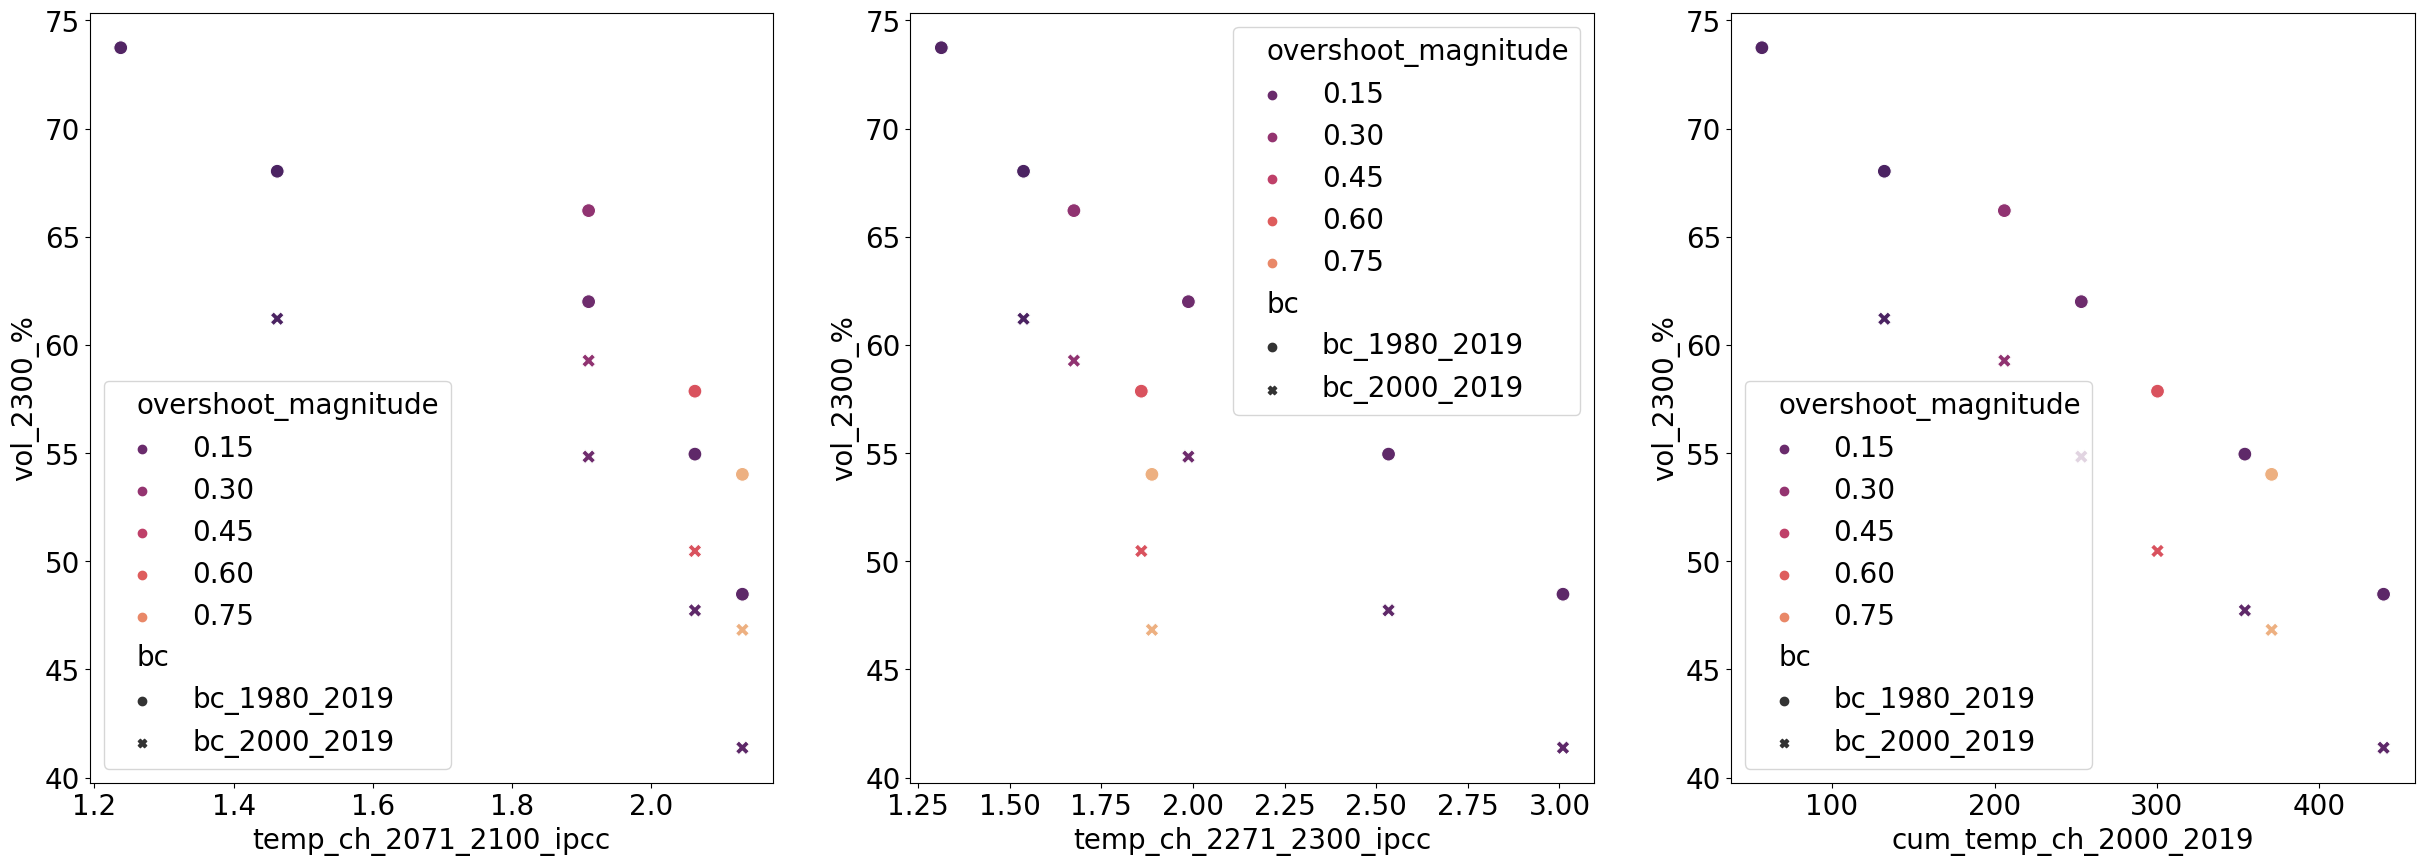

In [12]:
plt.rc('font', size=20)

plt.figure(figsize=(30,10))

plt.subplot(131)
sns.scatterplot(data=pd_cum_glob_temp_ch_vs_volume_ch_all,
               y='vol_2300_%', x='temp_ch_2071_2100_ipcc', color='black', style='bc',s=100,
                hue='overshoot_magnitude', palette='flare_r')
plt.subplot(132)
sns.scatterplot(data=pd_cum_glob_temp_ch_vs_volume_ch_all,
               y='vol_2300_%', x='temp_ch_2271_2300_ipcc', color='black', style='bc', #hue='overshoot'
                 hue='overshoot_magnitude', palette='flare_r',s=100,
               )
plt.subplot(133)

sns.scatterplot(data=pd_cum_glob_temp_ch_vs_volume_ch_all,
               y='vol_2300_%', x='cum_temp_ch_2000_2019', color='black', style='bc', #hue='overshoot'
                hue='overshoot_magnitude', palette='flare_r', s=100,
               )

#sns.scatterplot(data=pd_cum_glob_temp_ch_vs_volume_ch_all.loc[pd_cum_glob_temp_ch_vs_volume_ch_all.overshoot=='yes'],
#               y='vol_2300_%', x='cum_temp_ch_2000_2019', color='grey', style='bc', hue='overshoot')

Text(0.5, 0, 'Cumulative global warming until 2300 (°C)\n(sum of annual temperatures relative to global mean 2000-2019)')

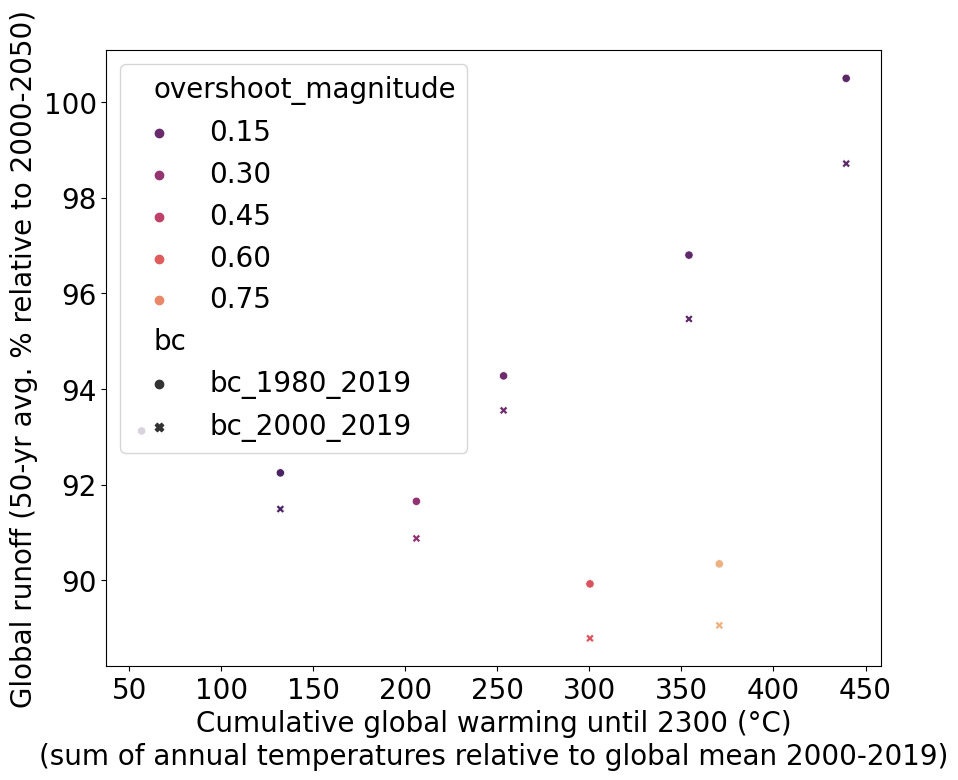

In [13]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=pd_cum_glob_temp_ch_vs_volume_ch_all,
               y='runoff_2300_50_yr_avg_%', x='cum_temp_ch_2000_2019',
                hue='overshoot_magnitude', style='bc', palette='flare_r')
plt.ylabel('Global runoff (50-yr avg. % relative to 2000-2050)')
plt.xlabel('Cumulative global warming until 2300 (°C)\n(sum of annual temperatures relative to global mean 2000-2019)')

In [14]:
fpath = '/home/www/oggm/oggm-standard-projections/oggm-standard-projections-csv-files/1.6.1/common_running_2100_2300/volume'
gcms_cmip6_2300 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list_2300.csv', index_col=0)  
gcms_cmip5_2300 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list_2300.csv', index_col=0)  

scenarios_cmip5 = ['rcp26', 'rcp45']
scenarios_cmip6 = ['ssp126','ssp534-over']
pa='/home/www/oggm/oggm-standard-projections/analysis_notebooks'
df_scenario_cmip6_2300_runoff = xr.open_dataset(f'{pa}/runoff_evol_per_rgi_reg_common_running_glaciers_oggm_all_exp_v16_2023.3_bc_2000_2019_{cmip}_endyr{endyr}.nc')
df_scenario_cmip6_2300_runoff = df_scenario_cmip6_2300_runoff.sel(hist='w5e5_gcm_merged')


In [15]:
endyr = 2300
pd_cum_glob_temp_ch_vs_volume_ch = pd.DataFrame(columns =['cum_temp_ch_2000_2019'])
for cmip, scenarios in zip(['CMIP5', 'CMIP6'], [scenarios_cmip5, scenarios_cmip6]):
    if cmip == 'CMIP6':
        gcms_cmip_2300 = gcms_cmip6_2300
    else:
        gcms_cmip_2300 = gcms_cmip5_2300

    for scenario in scenarios: # ,'ssp585']: (those are just too extreme, we don't want them...)
        gcms_cmip_2300_over = gcms_cmip_2300.loc[(gcms_cmip_2300[scenario[:3]] ==scenario) & (gcms_cmip_2300['var'] =='tas')]
        for f in gcms_cmip_2300_over.index:
            gcm = gcms_cmip_2300_over.loc[f]['gcm']
            dtas_annual = xr.open_dataset(gcms_cmip_2300_over.loc[f]['path'],
                                          use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()
            weight = np.cos(np.deg2rad(dtas_annual.lat))
            weight = weight / weight.sum()

            # get the global means for every month:        
            global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
            global_dtas_50yr = global_dtas.rolling(year=50, center = True).mean().dropna(dim='year')
            diff_max_end_global_tas = (global_dtas_50yr.max() - global_dtas_50yr.isel(year=-1)).values
            _temp_ch_cum_sum = (global_dtas - global_dtas.sel(year=slice(2000,2019)).mean().values).sum().values
            _deltaT_2100 = global_dtas.sel(year=slice(2071,2100)).mean() - global_dtas.sel(year=slice(1986,2005)).mean() +0.69
            _deltaT_2300 = global_dtas.sel(year=slice(2271,2300)).mean() - global_dtas.sel(year=slice(1986,2005)).mean() +0.69
            
            for model in ['OGGM','PyGEM-OGGM','GloGEM']:
                if (model == 'GloGEM') and (cmip == 'CMIP5'):
                    continue
                #if model in ['PyGEM-OGGM','GloGEM']:
                _fpath_other_gmodels = '/home/users/lschuster/glacier-model-projections-until2300/glacier_model_csv_files'
                fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/global/{scenario}.csv'
                #else:
                #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
                pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
                pd_cmip_scen = pd_cmip_scen.dropna()
                pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}',
                                                 'cum_temp_ch_2000_2019'] = _temp_ch_cum_sum

                pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}',
                                                 'temp_ch_2071_2100_ipcc'] = _deltaT_2100

                pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}',
                                                 'temp_ch_2271_2300_ipcc'] = _deltaT_2300
                try:
                    pd_cmip_scen.columns = [c.upper() for c in pd_cmip_scen.columns]
                    df_scenario_cmip_2300_s = pd_cmip_scen[gcm.upper()]

                    df_scenario_cmip_2300_vol_s_rel = 100*df_scenario_cmip_2300_s.loc[2300]/df_scenario_cmip_2300_s.loc[2020]

                    pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}',
                                                         'vol_2300_%'] = df_scenario_cmip_2300_vol_s_rel
                    
                    
                    if scenario =='ssp534-over':
                        pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}',
                                                             'overshoot'] = 'yes' # (SSP 5-3.4'
                    elif scenario == 'ssp126':
                        pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}',
                                                             'overshoot'] = 'small (SSP 1-2.6)'
                    else:
                        pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}',
                                                     'overshoot'] = 'no' # (CMIP5)'
                    pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}', 'overshoot_magnitude'] = diff_max_end_global_tas
                    pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}','gcm'] = f'CMIP'
                    pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_{cmip}_{model}','Model'] = f'{model}'
                    
                    
                    
                except:
                    print(f'{gcm}_{scenario}_{cmip}_{model}')
            
            if cmip == 'CMIP6':
                df_scenario_cmip6_2300_s_runoff = df_scenario_cmip6_2300_runoff.sel(gcm_scenario=f'{gcm}_{scenario}').sum(dim='rgi_reg').runoff
                init_runoff = df_scenario_cmip6_2300_s_runoff.sel(time=slice(2000,2050)).mean(dim='time')
                df_scenario_cmip6_2300_s_runoff = 100*df_scenario_cmip6_2300_s_runoff.sel(time=slice(2250,2300)).mean(dim='time')/init_runoff
                pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{scenario}_CMIP6_OGGM',
                                                             'runoff_2300_50_yr_avg_%'] = df_scenario_cmip6_2300_s_runoff.values

IPSL-CM6A-LR_ssp534-over_CMIP6_GloGEM


In [17]:
#pd_cum_glob_temp_ch_vs_volume_ch = pd_cum_glob_temp_ch_vs_volume_ch.astype('float')
pd_cum_glob_temp_ch_vs_volume_ch['bc'] = 'bc_2000_2019'
pd_cum_glob_temp_ch_vs_volume_ch_all['Model'] = 'OGGM'
ALL_cum_glob_temp_ch_vs_volume_ch_all = pd.concat([pd_cum_glob_temp_ch_vs_volume_ch_all,
                                                  pd_cum_glob_temp_ch_vs_volume_ch])
ALL_cum_glob_temp_ch_vs_volume_ch_all[['cum_temp_ch_2000_2019', 'vol_2300_%',
                                       'runoff_2300_50_yr_avg_%']] = ALL_cum_glob_temp_ch_vs_volume_ch_all[['cum_temp_ch_2000_2019',
                                                                                                            'vol_2300_%','runoff_2300_50_yr_avg_%']].astype(float)

In [18]:
ALL_cum_glob_temp_ch_vs_volume_ch_all['gcm_bc'] = ALL_cum_glob_temp_ch_vs_volume_ch_all['gcm'] +  '\n' + ALL_cum_glob_temp_ch_vs_volume_ch_all['bc']

In [19]:
ALL_cum_glob_temp_ch_vs_volume_ch_all[['cum_temp_ch_2000_2019', 'vol_2300_%',
                                       'runoff_2300_50_yr_avg_%', 'Model']].dropna()

,cum_temp_ch_2000_2019,vol_2300_%,runoff_2300_50_yr_avg_%,Model
stab_T12,56.821447,73.740417,93.122025,OGGM
stab_T15,132.175887,68.029755,92.245483,OGGM
oversh_T20OS15,206.050516,66.209450,91.650368,OGGM
oversh_T25OS15,300.327276,57.861519,89.923370,OGGM
oversh_T30OS15,370.562555,54.015999,90.341980,OGGM
stab_T20,253.415420,61.999664,94.274063,OGGM
stab_T25,354.090339,54.951660,96.801010,OGGM
stab_T30,439.475723,48.474842,100.498161,OGGM
stab_T15,132.175887,61.211124,91.488838,OGGM
oversh_T20OS15,206.050516,59.272465,90.874741,OGGM


In [20]:
oggm_cum_glob_temp_ch_vs_volume_ch_all = ALL_cum_glob_temp_ch_vs_volume_ch_all.loc[ALL_cum_glob_temp_ch_vs_volume_ch_all.Model == 'OGGM']
other_models_cum_glob_temp_ch_vs_volume_ch_all = ALL_cum_glob_temp_ch_vs_volume_ch_all.loc[ALL_cum_glob_temp_ch_vs_volume_ch_all.Model != 'OGGM']

In [21]:
ALL_cum_glob_temp_ch_vs_volume_ch_all['gcm_bc'].unique()

array(['gfdl-esm2m\nbc_1980_2019', 'gfdl-esm2m\nbc_2000_2019',
       'CMIP\nbc_2000_2019', nan], dtype=object)

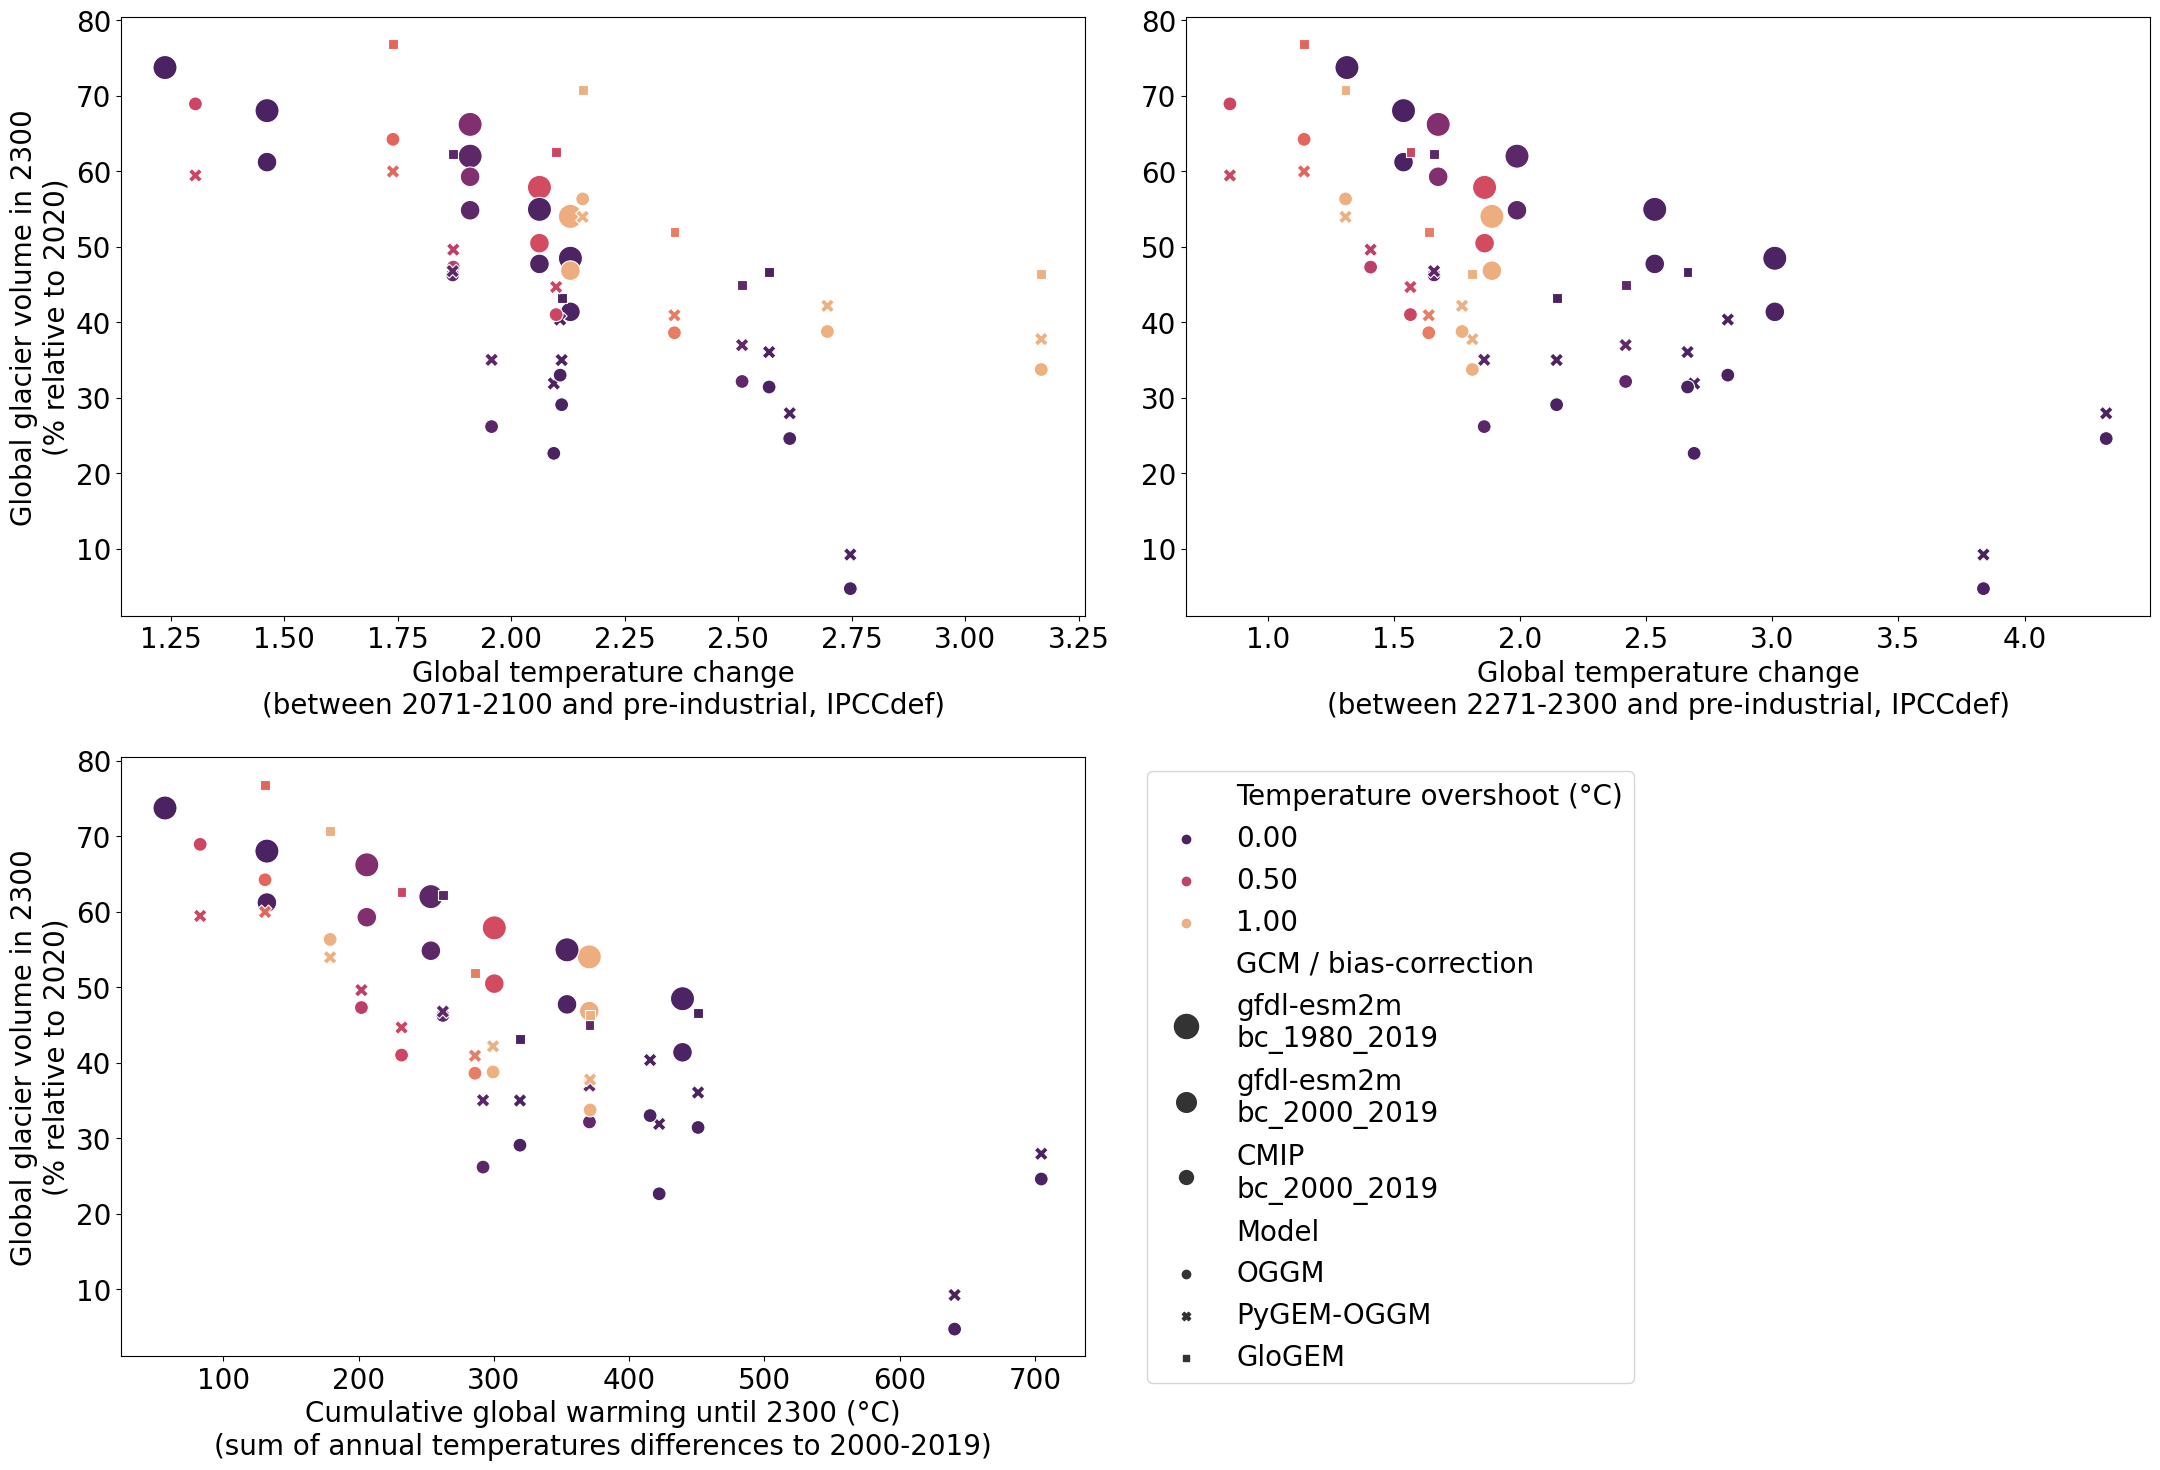

In [22]:
plt.rc('font', size=20)
norm = plt.Normalize(vmin=0.1,vmax=0.9)

plt.figure(figsize=(22,16))
plt.subplot(221)
sns.scatterplot(data=ALL_cum_glob_temp_ch_vs_volume_ch_all,
               y='vol_2300_%', x='temp_ch_2071_2100_ipcc', 
                style='Model',
                style_order=['OGGM', 'PyGEM-OGGM', 'GloGEM'],
                #style_order = ['no','yes', 'small (SSP 1-2.6)'], 
                size_order = ['gfdl-esm2m\nbc_1980_2019','gfdl-esm2m\nbc_2000_2019', 'CMIP\nbc_2000_2019'],
                hue='overshoot_magnitude', palette='flare_r',# s=100,
                size='gcm_bc', sizes =  [300,200,100], legend=False,
               hue_norm = norm)
plt.ylabel('Global glacier volume in 2300\n(% relative to 2020)')
plt.xlabel('Global temperature change\n(between 2071-2100 and pre-industrial, IPCCdef)')


plt.subplot(222)
sns.scatterplot(data=ALL_cum_glob_temp_ch_vs_volume_ch_all,
               y='vol_2300_%', x='temp_ch_2271_2300_ipcc', 
               style='Model',
                style_order=['OGGM', 'PyGEM-OGGM', 'GloGEM'],
                #style_order = ['no','yes', 'small (SSP 1-2.6)'], 
                size_order = ['gfdl-esm2m\nbc_1980_2019','gfdl-esm2m\nbc_2000_2019', 'CMIP\nbc_2000_2019'],
                hue='overshoot_magnitude', palette='flare_r',# s=100,
                size='gcm_bc', sizes = [300,200,100], legend=False,
               hue_norm = norm)

plt.ylabel('')
plt.xlabel('Global temperature change\n(between 2271-2300 and pre-industrial, IPCCdef)')

plt.subplot(223)
sns.scatterplot(data=ALL_cum_glob_temp_ch_vs_volume_ch_all,
               y='vol_2300_%', x='cum_temp_ch_2000_2019', style='Model',
                style_order=['OGGM', 'PyGEM-OGGM', 'GloGEM'],
                #style_order = ['no','yes', 'small (SSP 1-2.6)'], 
                #size_order = ['gfdl-esm2m_bc_1980_2019','gfdl-esm2m_bc_2000_2019', 'CMIP_bc_2000_2019'],
                size_order = ['gfdl-esm2m\nbc_1980_2019','gfdl-esm2m\nbc_2000_2019', 'CMIP\nbc_2000_2019'],
                hue='overshoot_magnitude', palette='flare_r',# s=100,
                size='gcm_bc', sizes = [300,200,100], legend='brief',
                hue_norm = norm
               )# size='overshoot')

plt.ylabel('Global glacier volume in 2300\n(% relative to 2020)')

plt.xlabel('Cumulative global warming until 2300 (°C)\n(sum of annual temperatures differences to 2000-2019)')
handles, labels = plt.gca().get_legend_handles_labels()

handles_n = [handles[0], handles[1], handles[3], handles[5]] + handles[7:]
labels_n = ['Temperature overshoot (°C)', labels[1], labels[3], labels[5]] + ['GCM / bias-correction']+ labels[8:]
plt.tight_layout()

plt.legend(handles_n, labels_n, ncol=1, loc= 'upper left', bbox_to_anchor=(1.05, 1))

plt.savefig('figures/4_discussion_gcm_gmodel_comparison.pdf')
plt.savefig('figures/4_discussion_gcm_gmodel_comparison.png')

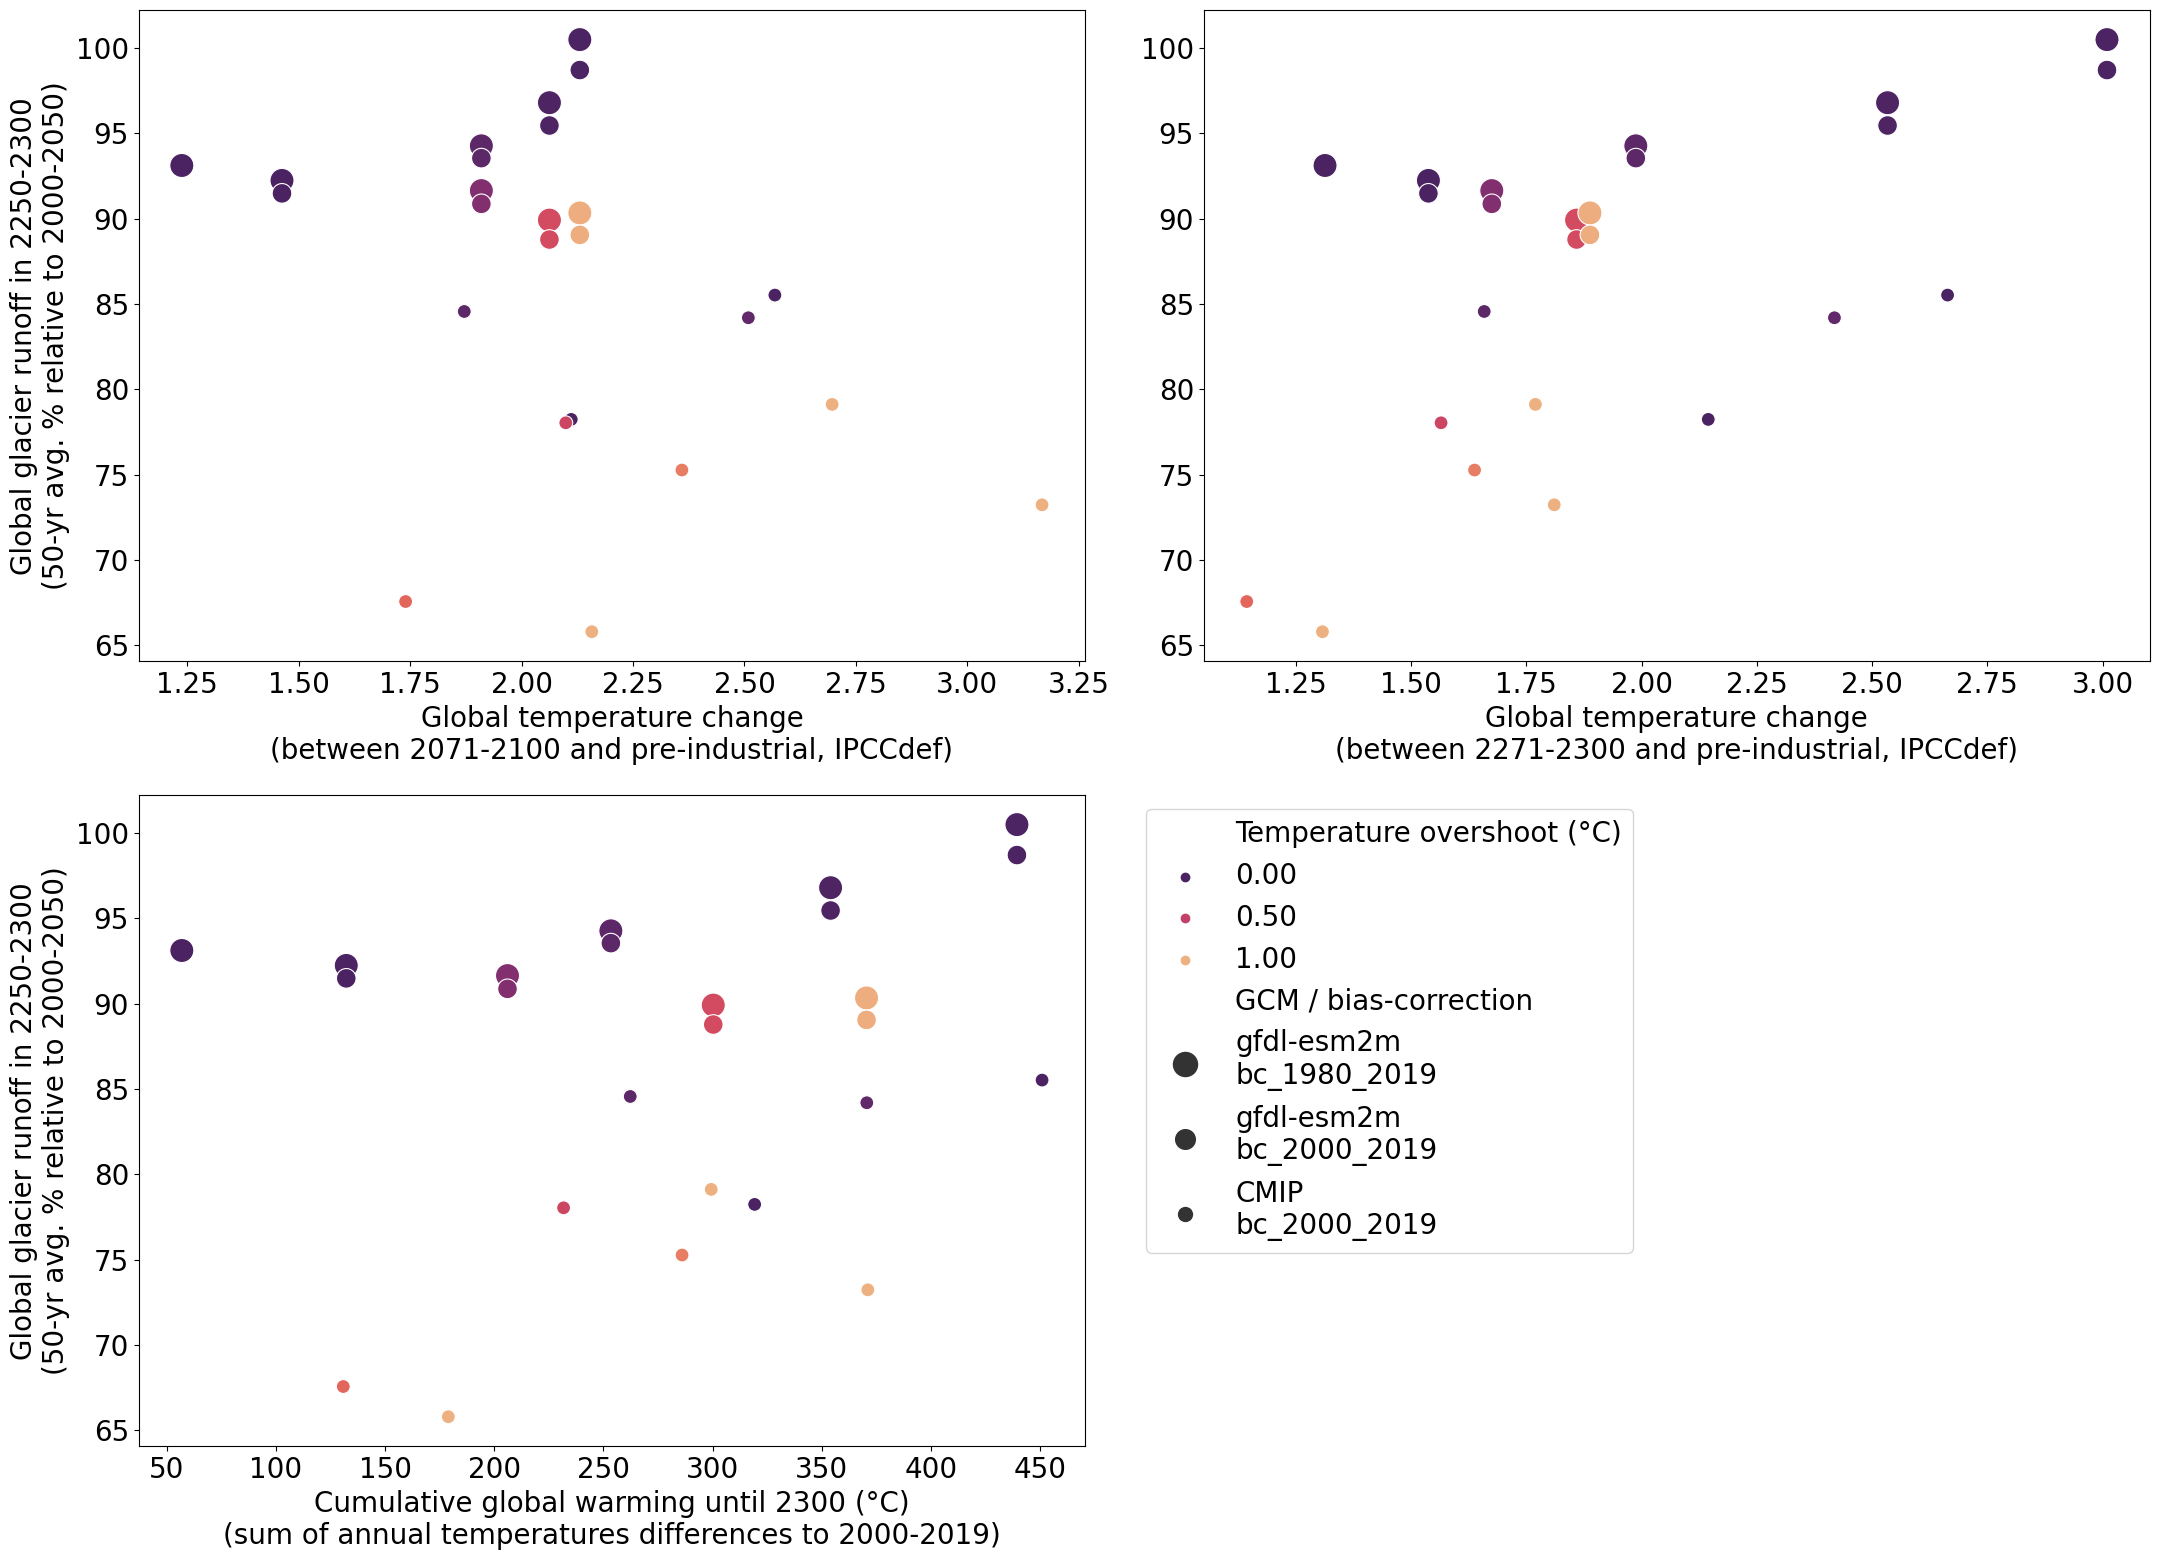

In [23]:
plt.rc('font', size=20)
norm = plt.Normalize(vmin=0.1,vmax=0.9)

plt.figure(figsize=(22,16))
plt.subplot(221)
sns.scatterplot(data=oggm_cum_glob_temp_ch_vs_volume_ch_all,
               y='runoff_2300_50_yr_avg_%', x='temp_ch_2071_2100_ipcc', 
                #style='Model',
                #style_order=['OGGM'],, 'PyGEM-OGGM', 'GloGEM'],
                #style_order = ['no','yes', 'small (SSP 1-2.6)'], 
                size_order = ['gfdl-esm2m\nbc_1980_2019','gfdl-esm2m\nbc_2000_2019', 'CMIP\nbc_2000_2019'],
                hue='overshoot_magnitude', palette='flare_r',# s=100,
                size='gcm_bc', sizes =  [300,200,100], legend=False,
               hue_norm = norm)
plt.ylabel('Global glacier runoff in 2250-2300\n(50-yr avg. % relative to 2000-2050)')

plt.xlabel('Global temperature change\n(between 2071-2100 and pre-industrial, IPCCdef)')


plt.subplot(222)
sns.scatterplot(data=oggm_cum_glob_temp_ch_vs_volume_ch_all,
               y='runoff_2300_50_yr_avg_%', x='temp_ch_2271_2300_ipcc', 
               #style='Model',
                #style_order=['OGGM', 'PyGEM-OGGM', 'GloGEM'],
                #style_order = ['no','yes', 'small (SSP 1-2.6)'], 
                size_order = ['gfdl-esm2m\nbc_1980_2019','gfdl-esm2m\nbc_2000_2019', 'CMIP\nbc_2000_2019'],
                hue='overshoot_magnitude', palette='flare_r',# s=100,
                size='gcm_bc', sizes = [300,200,100], legend=False,
               hue_norm = norm)

plt.ylabel('')
plt.xlabel('Global temperature change\n(between 2271-2300 and pre-industrial, IPCCdef)')

plt.subplot(223)
sns.scatterplot(data=oggm_cum_glob_temp_ch_vs_volume_ch_all,
               y='runoff_2300_50_yr_avg_%', x='cum_temp_ch_2000_2019', #style='Model',
                #style_order=['OGGM', 'PyGEM-OGGM', 'GloGEM'],
                #style_order = ['no','yes', 'small (SSP 1-2.6)'], 
                #size_order = ['gfdl-esm2m_bc_1980_2019','gfdl-esm2m_bc_2000_2019', 'CMIP_bc_2000_2019'],
                size_order = ['gfdl-esm2m\nbc_1980_2019','gfdl-esm2m\nbc_2000_2019', 'CMIP\nbc_2000_2019'],
                hue='overshoot_magnitude', palette='flare_r',# s=100,
                size='gcm_bc', sizes = [300,200,100], legend='brief',
                hue_norm = norm
               )# size='overshoot')

plt.ylabel('Global glacier runoff in 2250-2300\n(50-yr avg. % relative to 2000-2050)')

plt.xlabel('Cumulative global warming until 2300 (°C)\n(sum of annual temperatures differences to 2000-2019)')
handles, labels = plt.gca().get_legend_handles_labels()

handles_n = [handles[0], handles[1], handles[3], handles[5]] + handles[7:]
labels_n = ['Temperature overshoot (°C)', labels[1], labels[3], labels[5]] + ['GCM / bias-correction']+ labels[8:]
plt.tight_layout()

plt.legend(handles_n, labels_n, ncol=1, loc= 'upper left', bbox_to_anchor=(1.05, 1))

plt.savefig('figures/4_discussion_runoff_gcm_only_oggm_comparison.pdf')
plt.savefig('figures/4_discussion_runoff_gcm_only_oggm_comparison.png')

**OLD???**

In [211]:
# this is the old approach
pd_cum_glob_temp_ch_vs_volume_ch = pd.DataFrame(columns =['cum_temp_ch_2000_2019'])
df_scenario_cmip6_2300_runoff = xr.open_dataset(f'{pa}/runoff_evol_per_rgi_reg_common_running_glaciers_oggm_all_exp_v16_2023.3_bc_2000_2019_{cmip}_endyr{endyr}.nc')
df_scenario_cmip6_2300_runoff = df_scenario_cmip6_2300_runoff.sel(hist='w5e5_gcm_merged')
for ssp in ['ssp126','ssp534-over']: # ,'ssp585']: (those are just too extreme, we don't want them...)
    gcms_cmip6_2300_over = gcms_cmip6_2300.loc[(gcms_cmip6_2300.ssp ==ssp) & (gcms_cmip6_2300['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index:
        gcm = gcms_cmip6_2300_over.loc[f]['gcm']
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:        
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        _temp_ch_cum_sum = (global_dtas - global_dtas.sel(year=slice(2000,2019)).mean().values).sum().values
        pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{ssp}',
                                         'cum_temp_ch_2000_2019'] = _temp_ch_cum_sum
        
        df_scenario_cmip6_2300_s = df_scenario_cmip6_2300.sel(gcm_scenario=f'{gcm}_{ssp}').sum(dim='rgi_reg').volume
        df_scenario_cmip6_2300_s_runoff = df_scenario_cmip6_2300_runoff.sel(gcm_scenario=f'{gcm}_{ssp}').sum(dim='rgi_reg').runoff

        df_scenario_cmip6_2300_vol_s_rel = 100*df_scenario_cmip6_2300_s.isel(time=-1)/df_scenario_cmip6_2300_s.sel(time=2020)
        init_runoff = df_scenario_cmip6_2300_s_runoff.sel(time=slice(2000,2050)).mean(dim='time')
        df_scenario_cmip6_2300_s_runoff = 100*df_scenario_cmip6_2300_s_runoff.sel(time=slice(2250,2300)).mean(dim='time')/init_runoff
        pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{ssp}',
                                             'vol_2300_%'] = df_scenario_cmip6_2300_vol_s_rel.values
        pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{ssp}',
                                             'runoff_2300_50_yr_avg_%'] = df_scenario_cmip6_2300_s_runoff.values
        if ssp =='ssp534-over':
            pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{ssp}',
                                                 'overshoot'] = 'yes'
        else:
            pd_cum_glob_temp_ch_vs_volume_ch.loc[f'{gcm}_{ssp}',
                                                 'overshoot'] = 'small (ssp126)'

FileNotFoundError: [Errno 2] No such file or directory: b'/home/www/oggm/oggm_output/analysis_notebooks/runoff_evol_per_rgi_reg_common_running_glaciers_oggm_all_exp_v16_2023.3_bc_2000_2019_CMIP6_endyr2300.nc'

In [216]:
#pd_cum_glob_temp_ch_vs_volume_ch = pd_cum_glob_temp_ch_vs_volume_ch.astype('float')
pd_cum_glob_temp_ch_vs_volume_ch['bc'] = 'bc_2000_2019'
pd_cum_glob_temp_ch_vs_volume_ch['gcm'] = 'from_cmip6'
pd_cum_glob_temp_ch_vs_volume_ch_all = pd.concat([pd_cum_glob_temp_ch_vs_volume_ch_all,
                                                  pd_cum_glob_temp_ch_vs_volume_ch])
pd_cum_glob_temp_ch_vs_volume_ch_all[['cum_temp_ch_2000_2019', 'vol_2300_%']] = pd_cum_glob_temp_ch_vs_volume_ch_all[['cum_temp_ch_2000_2019', 'vol_2300_%']].astype(float)

Text(0.5, 0, 'Cumulative global warming until 2300 (°C)\n(sum of annual temperatures relative to global mean 2000-2019)')

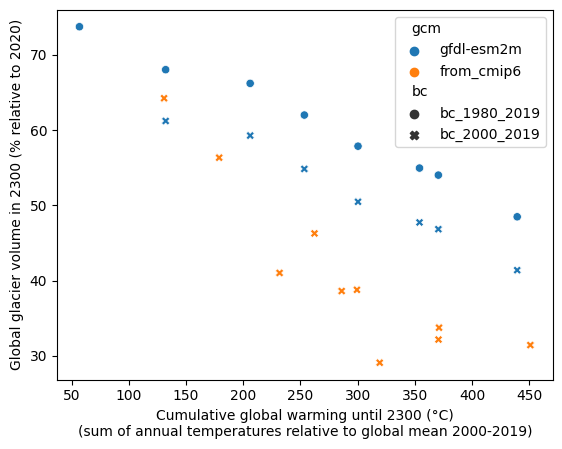

In [219]:
sns.scatterplot(data=pd_cum_glob_temp_ch_vs_volume_ch_all,
               y='vol_2300_%', x='cum_temp_ch_2000_2019', hue='gcm', style='bc',
               )# size='overshoot')
plt.ylabel('Global glacier volume in 2300 (% relative to 2020)')
plt.xlabel('Cumulative global warming until 2300 (°C)\n(sum of annual temperatures relative to global mean 2000-2019)')

- attention: the gfdl-esm2m bc_2000_2019 stab_T12 has not been run yet (i.e., a missing blue cross at around x=50)

Text(0.5, 0, 'Cumulative global warming until 2300 (°C)\n(sum of annual temperatures relative to global mean 2000-2019)')

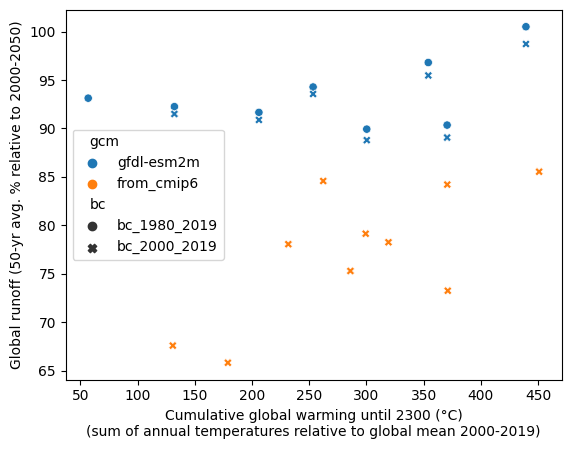

In [222]:
sns.scatterplot(data=pd_cum_glob_temp_ch_vs_volume_ch_all,
               y='runoff_2300_50_yr_avg_%', x='cum_temp_ch_2000_2019',
                hue='gcm', style='bc') #, size='overshoot')
plt.ylabel('Global runoff (50-yr avg. % relative to 2000-2050)')
plt.xlabel('Cumulative global warming until 2300 (°C)\n(sum of annual temperatures relative to global mean 2000-2019)')